In [327]:
! ls *.py

credentials.py getFEC_v2.py   getPARTY_2.py
getFEC.py      getPARTY.py    run.py


In [2]:
import time
import pandas as pd
import numpy as np
from collections import Counter


def first_sample(n, sample_size):
    sample_frame = np.random.choice(n, size=n, replace=False, p=None)
    a = np.random.choice(n, size=sample_size, replace=False, p=None)
    return(sample_frame, a)


def resample_one(first_sample):

    sframe = first_sample[0]
    sample = first_sample[1]
    
    sframe = np.setdiff1d(sframe, sample)   
    sample = np.random.choice(sframe, size=1, replace=False, p=None)
    
    return(sframe, sample)


def all_samples(n, first_sample_size=3):        

    s0 = first_sample(n, first_sample_size)
    sr = s0
    count = len(np.atleast_1d(sr[0]))
    samples = [s0[1].tolist()]

    if n == first_sample_size:
        return(samples)
    else:
        pass

    while len(np.atleast_1d(sr[0])) != 1:
        if count == n:
            s1 = resample_one(s0)
            count -=1
            samples.append(s1[1].tolist())
            sr = (s1)
        else:
            sn = resample_one(sr)
            sr = (sn)
            samples.append(sn[1].tolist())     
    else:
        pass

    #print(samples)
    return(samples)
    
s = all_samples(10, 1)

rid = None

def get_rid(rid):
    sample_index = 0
    while rid is None:
        sample_index +=1
        rid = s[sample_index][0]
        #print(rid)
    else:
        return rid

get_rid(rid)





1

In [329]:
pid_1 = "dog"
pid_2 = "dog"
pid_3 = "cat"
party_id = Counter([pid_1, pid_2, pid_3]).most_common(1)[0][0]
party_id

'dog'

In [330]:
from credentials import *
import requests
import json, csv
import warnings
import random

from getFEC import *


def get_party_id(committee_id):
    stem = "https://api.open.fec.gov/v1/committee/"
    end = "{}/candidates/?sort=name&page=1&api_key={}&per_page=100".format(committee_id, api_key)
    url = stem+end

    data = get_url(url)['results']
    if len(data) <= 0:
        warnings.warn('WARNING: get_party_id search by committee id returns no results, try another method')
        return ("UNKNOWN PARTY ID")
    else:
        party_id = data[0]['party_full']
        return party_id


def get_committee_details(committee_id):
    stem = "https://api.open.fec.gov/v1/committee/"
    end = "{}/?sort=name&api_key={}&per_page=100&page=1".format(committee_id, api_key)
    url = stem+end

    data = get_url(url)['results']
    party_id = data[0]['party_full']
    candidate_ids = data[0]['candidate_ids']
    #office = data[0]['office_full']
    #name = data[0]['name']
    #return data[0]['party']
    return party_id, candidate_ids

def alt_receipt_id(rid, s, sample_frame):
    if rid == None:
        available = s
        next_sample = random.sample(set(sample_frame))
        r_new = r

def get_schedule_b_receipts(committee_id, year=None):
    stem = "https://api.open.fec.gov/v1/committee/{}/schedules/".format(committee_id)
    end = "schedule_b/by_recipient_id/?per_page=20&api_key={}&page=1".format(api_key)
    
    if year is not None:
        #end += "&cycle={}".format(year)
        if len(get_url(stem+end+"&cycle={}".format(year))['results']) >0:
            end += "&cycle={}".format(year)
        else:
            pass
            
    else:
        pass
    
    url = stem+end
    print(url)
    
    #import pdb
    #pdb.set_trace()

    data = get_url(url)['results']
    if len(data) <= 0:
        warnings.warn('WARNING: get_schedule_b_receipts search by committee id returns no results, try another method')
        return None
    elif len(data) > 0 and len(data) < 3:
        return data[0]['recipient_id']
    elif len(data) > 0 and len(data) >= 3:
        
        s = all_samples(len(data), 3)

        def get_rid(rid, sample_index=0):
            while rid is None:
                sample_index +=1
                #print(s[sample_index][0])
                rid = data[s[sample_index][0]]['recipient_id']
                #print("none", rid)
            else:
                return rid, sample_index
        
        r1 = get_rid(data[s[0][0]]['recipient_id'], 0)
        r2 = get_rid(data[s[0][1]]['recipient_id'], r1[1])
        r3 = get_rid(data[s[0][2]]['recipient_id'], r2[1])
    
        #print(r1, r2, r3)
        return [r1[0], r2[0], r3[0]]
    else:
        pass

def find_schedule_b_results(committee_ids):
    if type(committee_ids) is list:
        cids = committee_ids
    else:
        cids = [committee_ids]
    assert len(cids) > 0

    #print(cids)
    
    if len(cids) == 1:
        #print(cids)
        party_id = get_committee_details(cids[0])[0]
        return party_id
    else:

        pid_1 = get_committee_details(cids[0])[0]
        pid_2 = get_committee_details(cids[1])[0]
        pid_3 = get_committee_details(cids[2])[0]
        #print(pid_1, pid_2, pid_3)
        if (pid_1 == pid_2 == pid_3) is True:
            party_id = pid_1
            return party_id
        else:
            party_id = list(Counter([pid_1, pid_2, pid_3]).most_common(1))[0][0]
            #print("UNCLEAR Schedule B")
            #print(pid_1, pid_2, pid_3)
            #return "UNCLEAR Schedule B Party ID"
            return(party_id)


def search_party_id(committee_id, year=None):
    #TODO add years to other searches where applicable
    try:
        party_results = get_committee_details(committee_id)
        time.sleep(0.5)

        if party_results[0] is None and len(party_results[1]) == 0:
            #print("no party results, further_tests_needed", party_results)
            print("[*] conducting schedule b search...")
            #import pdb
            #pdb.set_trace()

            schedule_b_receipts = get_schedule_b_receipts(committee_id, year)
            party_id = find_schedule_b_results(schedule_b_receipts)
            #return party_id

        elif party_results[0] is None and len(party_results[1]) > 0:
            print("[*] candidate id exists but no party results", party_results)
            #try get_party_id search
            party_id = get_party_id(committee_id)
            #return party_id

        elif party_results[0] is not None:
            print("[*] party id found in committee details: ", party_results)
            party_id = party_results[0]
            #return party_id

        else:
            print("[*] pass, unknown results", party_results)
            party_id = "UNKNOWN D"
            #return party_id
    except:
        print("[*] unknown error, unknown results", party_results)
        party_id = "ERROR" 
        
    return party_id

#test_ids = ["C00401224", "C00000935", "C00464297", "C00571380"]
#test_manual_inf = ["dem pac", "dem comm", "rep can", "rep pac"]
#for cid  in test_ids:
#    party_id = search_party_id(cid)
#    print(party_id)


In [331]:
test_ids = ["C00401224", "C00000935", "C00464297", "C00571380", "C00230482", "C00606962"]
#test_ids = ["C00606962"]
#test_ids = ["C00401224"]
test_manual_inf = ["dem pac", "dem comm", "rep can", "rep pac"]
for cid  in test_ids:
    party_id = search_party_id(cid, 2012)
    print(party_id)

[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00401224/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
DEMOCRATIC PARTY
[*] party id found in committee details:  ('DEMOCRATIC PARTY', [])
DEMOCRATIC PARTY
[*] candidate id exists but no party results (None, ['S0NH00235'])
REPUBLICAN PARTY
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00571380/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1
REPUBLICAN PARTY
[*] candidate id exists but no party results (None, ['S0IA00028'])
REPUBLICAN PARTY
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00606962/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1
None


In [332]:
#extract party_id's from getFEC data


In [333]:
df = pd.read_csv("2012__Boeing__schedule_a_merged.csv")

In [334]:
df = df[['committee_id','cycle']].drop_duplicates()

In [335]:
#party_id = search_party_id(df.committee_id, df.cycle)
#n = len(df.index)
#Add Row to Data Frame
#df.loc[n] = 0
#df.ix[n, "party_id"] = date   
df.committee_id
df

,committee_id,cycle
0,C00341396,2012
1,C00003418,2012
2,C00401224,2012
4,C00142711,2012
1277,C00468314,2012
1278,C00424713,2012
1281,C00460758,2012
1285,C00458844,2012
2712,C00309567,2012
2713,C00349506,2012


In [336]:
#for cid  in committee_ids:
#    party_id = search_party_id(cid)
#    time.sleep(1)
#    print(party_id)

In [337]:
import numba

@numba.vectorize
def double_every_value_withnumba(x):
    return x*2

def assign_party_id2(cid, cycle):
    party_id = cid
    #party_id = search_party_id(cid, cycle)
    return party_id

@numba.vectorize
#@numba.jit(nopython=True)
def assign_party_id(cid, cycle):
    party_id = cid
    #party_id = search_party_id(cid, cycle)
    return party_id

#df['col1_doubled'] = double_every_value_withnumba(df.cycle.values)
#df['party_id'] = assign_party_id(df.committee_id.values, df.cycle.values)
df['new_column'] = np.vectorize(search_party_id)(df['committee_id'], df['cycle'])
df

[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00341396/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00341396/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] party id found in committee details:  ('REPUBLICAN PARTY', [])
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00401224/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00142711/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00468314/schedules/schedule_b/by_recipient_id/?per_pag

,committee_id,cycle,new_column
0,C00341396,2012,DEMOCRATIC PARTY
1,C00003418,2012,REPUBLICAN PARTY
2,C00401224,2012,DEMOCRATIC PARTY
4,C00142711,2012,REPUBLICAN PARTY
1277,C00468314,2012,DEMOCRATIC PARTY
1278,C00424713,2012,DEMOCRATIC PARTY
1281,C00460758,2012,REPUBLICAN PARTY
1285,C00458844,2012,REPUBLICAN PARTY
2712,C00309567,2012,DEMOCRATIC PARTY
2713,C00349506,2012,DEMOCRATIC PARTY


In [338]:
df = pd.read_csv("2012__Goldman_Sachs__schedule_a_merged.csv")
df = df[['committee_id','cycle']].drop_duplicates()
df['new_column'] = np.vectorize(search_party_id)(df['committee_id'], df['cycle'])

[*] party id found in committee details:  ('DEMOCRATIC PARTY', [])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', [])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['S4IN00014'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', [])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['S2KY00012'])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H0NY14189'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', [])
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00346015/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] conducting schedule b search...
https://api.open.fec.gov/v1/committee/C00247403/schedules/schedule_b/by_recipient_id/?per_page=20&api_key=AcVZVok6ajttkDVo4aQBvIyfgMLC2dEPjvtDrAUB&page=1&cycle=2012
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H2MD05155'])
[*] party id found

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:65: UserWarning: WARNING: get_schedule_b_receipts search by committee id returns no results, try another method


[*] unknown error, unknown results (None, [])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H2NJ07168'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['H0SC01279'])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H8CA12098'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['H8FL22038'])
[*] party id found in committee details:  ('OTHER', ['P20002523'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['H0CT05119'])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H0IL05096'])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H4CA12055'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['H8NJ05052'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['P80000748'])
[*] party id found in committee details:  ('DEMOCRATIC PARTY', ['H4NY11138'])
[*] party id found in committee details:  ('REPUBLICAN PARTY', ['H2CT04043'])
[*] party id found in committ

In [342]:
df.shape
df

,committee_id,cycle,new_column
0,C00010603,2012,DEMOCRATIC PARTY
1,C00122176,2012,REPUBLICAN PARTY
2,C00027466,2012,REPUBLICAN PARTY
3,C00193342,2012,REPUBLICAN PARTY
4,C00469866,2012,DEMOCRATIC PARTY
5,C00075820,2012,REPUBLICAN PARTY
6,C00346015,2012,DEMOCRATIC PARTY
7,C00247403,2012,REPUBLICAN PARTY
8,C00140715,2012,DEMOCRATIC PARTY
11,C00413914,2012,DEMOCRATIC PARTY


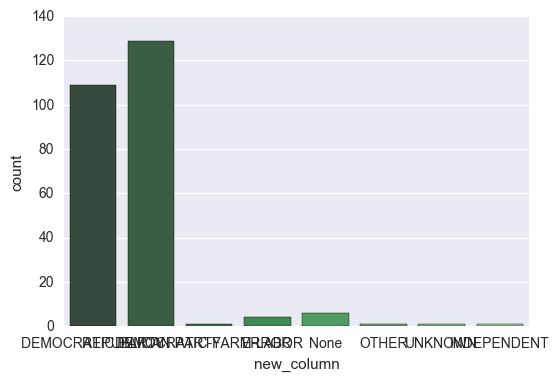

In [348]:
%matplotlib inline
import seaborn as sns
#sns.barplot(x="new", y="value", data=chicago_temps);
#f, ax = plt.subplots(figsize=(7, 3))
#sns.countplot(y="new_column", data=df, color="c");
sns.countplot(x="new_column", data=df, palette="Greens_d");

In [3]:
df_party = pd.read_csv("2012__Boeing__schedule_a_merged_PARTY_IDs.csv")
df_contrib = pd.read_csv("2012__Boeing__schedule_a_merged.csv")



In [9]:
frames = [df_contrib, df_party]
df_merged = pd.concat(frames, join="outer")
df_merged.head()

,Unnamed: 0,amendment_indicator,amendment_indicator_desc,back_reference_schedule_name,back_reference_transaction_id,candidate_first_name,candidate_id,candidate_last_name,candidate_middle_name,candidate_name,...,receipt_type_full,report_type,report_year,schedule_type,schedule_type_full,sub_id,timestamp,transaction_id,two_year_transaction_period,unused_contbr_id
0,NaN,A,ADD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MY,2011.0,SA,ITEMIZED RECEIPTS,4.081820e+18,2017-08-29T20:33:34.695796+00:00,4045568,2012.0,NaN
1,NaN,N,NO CHANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,M2,2011.0,SA,ITEMIZED RECEIPTS,4.081020e+18,2017-08-29T20:33:34.695796+00:00,2011M02L11AI00914,2012.0,NaN
2,NaN,N,NO CHANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EARMARK,M2,2011.0,SA,ITEMIZED RECEIPTS,4.021020e+18,2017-08-29T20:33:34.695796+00:00,SA11AI_2992266,2012.0,NaN
3,NaN,N,NO CHANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CONTRIBUTION TO ACT BLUE,M2,2011.0,SA,ITEMIZED RECEIPTS,4.021020e+18,2017-08-29T20:33:34.695796+00:00,SA11AI_2992267,2012.0,NaN
4,NaN,A,ADD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,M2,2011.0,SA,ITEMIZED RECEIPTS,4.031620e+18,2017-08-29T20:33:34.695796+00:00,2011010500000250,2012.0,NaN
